# Simulating fish nest with Lattice Boltzmann D2Q9
Inspiration for this simulation [here](https://www.youtube.com/watch?v=JFWqCQHg-Hs&t=683s).

The code is divided into a streaming and ... component. 

Works by splitting domain into a lattice, each one has nine potential velocites. 
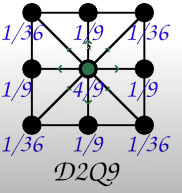
In the image above, the velocity going upwards transvers it's velocity upwards. Each direction has a probability of happening. For example 1/9 chance of going directly up, down, right or left. 
Each potential velocity is called a node, the probability is the __discrete velocity: ex(1,0)__.


In [43]:
import numpy as np
from matplotlib import pyplot, transforms
from image_extract import get_obstacle
import matplotlib.animation as animation

In [2]:
def distance(x1, y1, x2, y2):
    return np.sqrt((x2-x1)**2 + (y2-y1)**2)

In [99]:
plot_every = 25 # 
frames = []

## Defining constants

|Constant|Explanation|
|---|---|
|Nx|Size of the lattice in x|
|Ny|Size of the lattice in y|
|tau| Kinematic viscosity / timescale|
|Nt|Ammount of iterations through times|
|cxy|9 possible discrete velocities in x (vector is [x, y]|
|cyx|Same as above but in y, the x dimension is in the corresponding index in cyx|
|weights|Probabilities the cell to take on a specific velocity, commes from connection of this method with the navier-Stokes equations, their sum is 1|


In [199]:
# define variables
Nx = 400 # width of the simulation
Ny = 25 # height of the simulation
tau = .53 # kinematic viscosity
Nt = 2000 # iterations through time

# lattice speeds ands weights
# defining discrete velocity
NL = 9
# the length of all these lists should be 9
cxs = np.array([0, 0, 1, 1, 1, 0, -1, -1, -1]) # checked
cys = np.array([0, 1, 1, 0, -1, -1,-1, 0, 1]) # checked
# define wiegths = values assigned to each of the note, linked to Navier-Stokes
weights = np.array([4/9, 1/9, 1/36, 1/9, 1/36, 1/9, 1/36, 1/9, 1/36]) # checked

# Initial conditions
## Adding slight inconsistencies (mesoscopic velocity)
F = np.ones((Ny, Nx, NL)) + .01 * np.random.randn(Ny, Nx, NL)
#                            ^
#                            |
#                   Random inconstencies


# At each cell in each ones of it's third node's add a value of 2.5
F[:, :, 3] = 2.5 # checked
F.shape

(25, 400, 9)

## Defining obstacle areas
- Define a table cylinder of same dimension as our simulation containing either true of false:
- True = Obstacle cell
- False = Empty cell, the fluid can circulate here

Nest is of dimension -> (23, 300) -> the structure rests on the higher values
Cylinder is of shape -> (30, 400)

(23, 300)
(25, 400)
(23, 300)
57


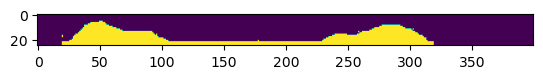

In [101]:
# creating obstacle
# start by making an new array with the same dimimentions as our simulation
cylinder = np.full((Ny, Nx), False) # if the value is false = empty space, else it's an obstacle
nest = get_obstacle() # return as np array containing either true of false

vertical_offset = cylinder.shape[0] - nest.shape[0]
print(cylinder.shape)
print(nest.shape)
print(offset)
for x in range(nest.shape[0]):
    for y in range(nest.shape[1]):
        cylinder[x+vertical_offset][y+20] = nest[x][y]

fig, ax = pyplot.subplots()
ax.imshow(cylinder)

## Main Loop
> Particles can do 2 things: Stream or collide
```
numpy.roll(a, shift, axis=None)[source]
```

### Fluid variables
Density, it's the sum of all the velocities: $$\rho=\sum{Fi}$$
Momentum: $$\rho u = \sum{F_iv_i}$$

#### F-Equilibrium
$$F^{eq}_i = w_ip(1+3(v_i . u) + \frac{9}{2}(v_i . u)^2 + \frac{3}{2}(u.u)^2$$
Corresponds to the isothermal Navier-Stokes equation: 
$$\mu=\rho(\tau - \frac{1}{2})\Delta t$$

Now that we have the calculated F equilibrium, we can calculate for the next timestep t by discretizing this equation : 
$$(\partial_t+v .\nabla)f = -\frac{f-f^{eq}}{\tau}$$
We then get : 
$$F_i(x_i+v_i\Delta t, t + \Delta t)-F_i(x_i, t)=-\frac{F(x_i, t) - F^{Eq}_i(x_i,t)}{\tau}$$
Where: 
- $F_i$ is the matrix
- TODO: finish defining the variables

In [161]:
for it in range(Nt): # iterating through time
        F[:, -1, [6, 7, 8]] = F[:, -2, [6, 7, 8]]
        F[:,  0, [2, 3, 4]] = F[:, 1, [2, 3, 4]]
        # streaming step: take every velocity and move it to it's neigbhours
        for i, cx, cy in zip(range(NL), cxs, cys):
            F[:, :, i] = np.roll(F[:, :, i], cx, axis=1)
            F[:, :, i] = np.roll(F[:, :, i], cy, axis=0)

        # calculating collisions
        bndryF = F[cylinder, :]
        # if the point is in the cylinder then invert the velocity to make it travel in the other direction
        bndryF = bndryF[:, [0, 5, 6, 7, 8, 1, 2, 3, 4]] # checked

        # defining variables for calculations
        rho = np.sum(F, 2) # density
        # now doing same thing for momentum
        ux = np.sum(F * cxs, 2)/rho # momentum
        uy = np.sum(F * cys, 2)/rho

        # apply boundaries, set all the lattices cells to opposites if they are in a boundary on in an obstacle
        F[cylinder, :] = bndryF # inverting the velocities where on the limit of a obstacle
        ux[cylinder] = 0 # cells in boundaries = 0
        uy[cylinder] = 0 # cells in boundaries = 0

        # collision
        Feq = np.zeros(F.shape) # f equilibrium
        for i, cx, cy, w in zip(range(NL), cxs, cys, weights):
            Feq[:, :, i] = rho * w * (
                1 + 3 * (cx*ux + cy*uy) + 9 * (cx*ux + cy*uy)**2 / 2 -3 * (ux**2 + uy**2)/2
            )
        F = F + -(1/tau) * (F-Feq)
    
        if (it%plot_every == 0):
            frames.append(np.sqrt(ux**2 + uy**2))
           
frames = frames[1:]

## Plotting

### Contour plot

/tmp/ipykernel_37248/1212439777.py:5: UserWarning: No contour levels were found within the data range.
  ax.contour(frames[2], transform= rot + base, levels=[1], colors='Red', vmin=0, vmax=maxou)
/tmp/ipykernel_37248/1212439777.py:14: UserWarning: No contour levels were found within the data range.
  ax.contour(frames[frame], transform= rot + base, levels=[1], colors='Red',vmin=0, vmax=maxou)


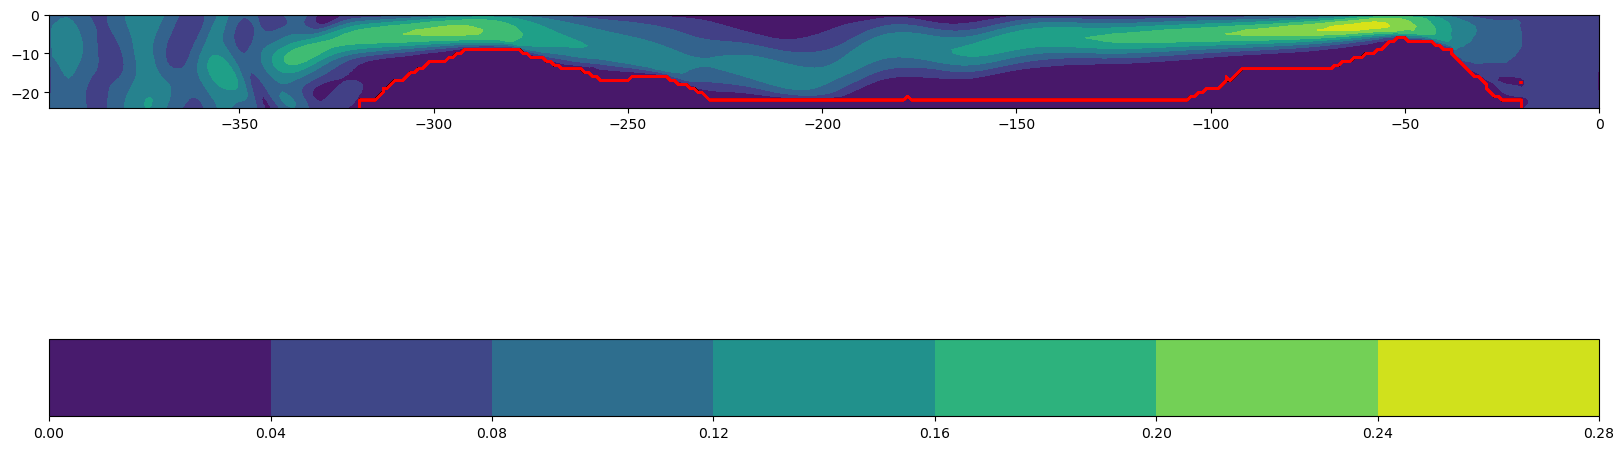

In [194]:
# TODO: make sure the color scale is correct all the way throught the simulation
fig, ax = plt.subplots(figsize=(20, 20))
base = fig.gca().transData
rot = transforms.Affine2D().rotate_deg(180)
im = ax.contourf(frames[2], transform= rot + base)
ax.contour(frames[2], transform= rot + base, levels=[1], colors='Red', vmin=0, vmax=maxou)

fig.colorbar(im, orientation='horizontal', extend="both")
ax.set_aspect('equal')


def update(frame):
    return (
        ax.contourf(frames[frame], transform= rot + base), 
        ax.contour(frames[frame], transform= rot + base, levels=[1], colors='Red',vmin=0, vmax=maxou)
    )

ani = animation.FuncAnimation(fig=fig, func=update, frames=len(frames)-2, interval=100)
ani.save(filename="jiba.gif", writer="pillow")

### Imshow

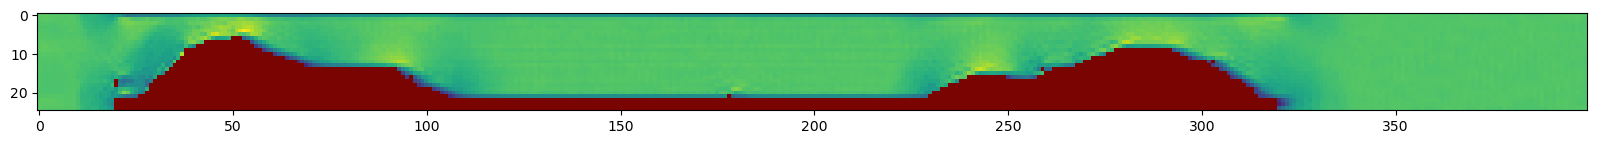

In [104]:
fig, ax = pyplot.subplots(figsize=(20, 20))

im = ax.imshow(frames[1])
# add nest outline
transparency_mask = np.zeros_like(cylinder, dtype=float)
transparency_mask[cylinder] = 1
ax.imshow(cylinder, alpha=transparency_mask, cmap='turbo', vmin=0, vmax=1)

# animating

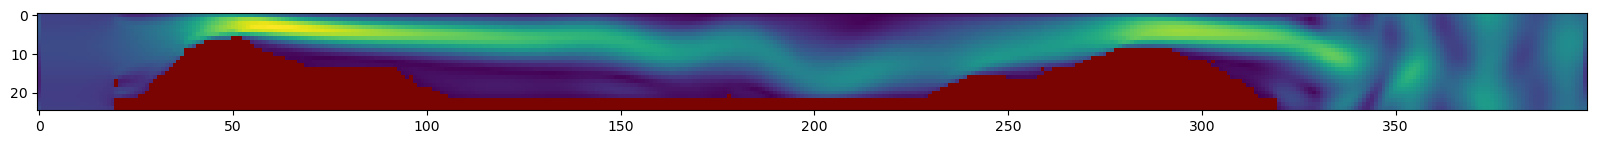

In [197]:
fig, ax = pyplot.subplots(figsize=(20, 20))

im = ax.imshow(frames[2])
transparency_mask = np.zeros_like(cylinder, dtype=float)
transparency_mask[cylinder] = 1
ax.imshow(cylinder, alpha=transparency_mask, cmap='turbo', vmin=0, vmax=1)


def update(frame):
    return (ax.imshow(frames[frame]), ax.imshow(cylinder, alpha=transparency_mask, cmap='turbo', vmin=0, vmax=1))

ani = animation.FuncAnimation(fig=fig, func=update, frames=len(frames)-2, interval=100)
ani.save(filename="jiba2.gif", writer="pillow")